# Data Cleaning and Analysis for Air pollution measurements at Ratnapark station

In [1]:
# author 'replytobishnu@gmail.com'
## ================================================ ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Pandas was unable to read the csv from link directly, changing ssl
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import warnings
warnings.filterwarnings("ignore")

url = 'https://opendatanepal.com/dataset/c3eff9e4-7783-4904-9e10-b3820b\
30041c/resource/f715980c-0897-4899-a9a5-fac8ca05122d/download/ratnapark.csv'

Read csv from url, parse the datetime and convert it from UTC to kathmandu time.

In [2]:
raw_data = pd.read_csv(url
                       , parse_dates=['datetime']
                       ,  date_parser=lambda col: pd.to_datetime(col).tz_convert('Asia/Kathmandu') 
                       )
raw_data.sample(2)

,station,particulate_matter,datetime,value
23172,Ratnapark,PM10,2019-05-14 01:13:00+05:45,92.5
44847,Ratnapark,TSP,2019-05-29 22:33:00+05:45,46.1


Cleaning steps:
1. It seems we have invalid rows ( 15 of them), with dates in the value column, deleting that row, and changing value column to float.
2. We have duplicate rows of data, removing those
3. The column 'particulate_matter' has a space in its header (column name). Correcting that.

- Putting all these in a function, as function makes it possible to make a pipeline later.

In [3]:
def clean_airpollution_data (raw_data):  # input raw dataframe

  # remove rows with invalid entries in value field.
  rows_removed = raw_data[ pd.to_numeric(raw_data['value'], errors='coerce').notnull()]
  rows_removed.loc[:, 'value'] = pd.to_numeric( rows_removed.value )
  # rename column as there is a space in the column name
  rows_removed.columns = ['station', 'particulate_matter', 'datetime'  ,'value']
  # check for duplicates, and remove duplicate rows
  nodup_data = rows_removed [ ~rows_removed.duplicated(subset=['station'
  , 'datetime','particulate_matter','value'], keep='first') ]
  nodup_data.set_index('datetime', inplace=True)
  return nodup_data

In [4]:
nodup_data = clean_airpollution_data( raw_data)

Pivot the table for ease of plotting, decided not to use pivot for now as it gave missing values 

In [5]:
# pivoted = pd.pivot(nodup_data, values= 'value' , index=['datetime','station']
#                    , columns=['particulate_matter'] )
# pivoted.sample(5)
# import matplotlib.pyplot as plt
# pivoted.isna().sum()
# padded quite a bit here, will look into the data more
# pivoted = pivoted.fillna(method="pad", limit=9)
# pivoted.isna().sum()

Pandas should recognize the time series automatically. 
Plotting the moving average on one weeks average basis. ( Assuming we have readings every half hour of the day, so 24*2 readings per day)

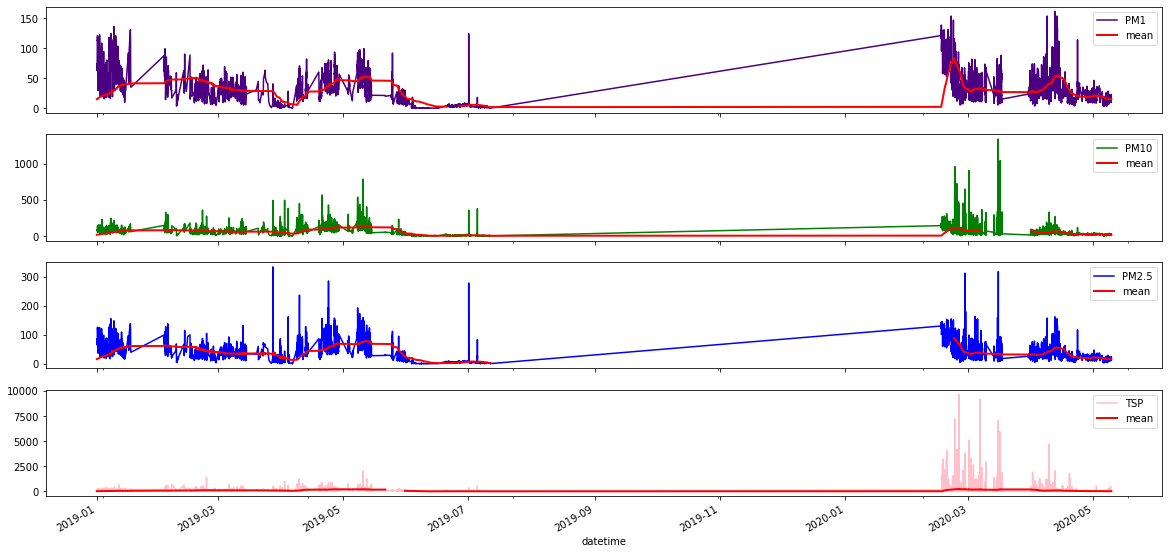

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex = True, figsize= (20,10))
color =['indigo','green','blue','pink']
for i, (name, group) in enumerate( nodup_data.groupby('particulate_matter')):
  # print(group)
  group.plot( y='value', label=name, ax = ax[i], color=color[i])
  group['rolling_mean'] = group['value'].rolling(window=24*14*2).mean() #biweekly
  group.plot( y='rolling_mean', label = 'mean', ax = ax[i],
             lw=2, color= 'red')

Observations from figures:
1. Data missing in station from 2019-07 to 2020-02 and also at 2020-03.
2. Pollution spikes in April-May months.

Next step:
Take the average of 3  hours of the day, and plot the time series again.
Also plot for 2 weeks, using the 14D as window

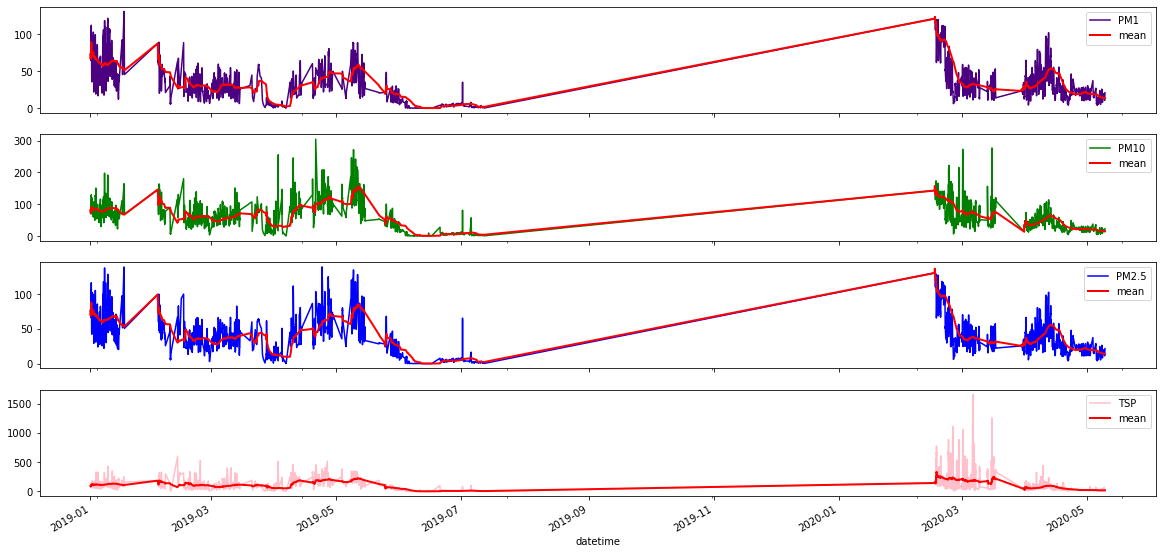

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex = True, figsize= (20,10))
color =['indigo','green','blue','pink']
for i, (name, group) in enumerate( nodup_data.groupby('particulate_matter')):
  group = group.sort_index()
  group['hour_mean'] = group['value'].rolling(window='3H').mean() #3 hourly
  group.plot( y='hour_mean', label=name, ax = ax[i], color=color[i])
  group['rolling_mean'] = group['value'].rolling(window='7D').mean() #biweekly
  group.plot( y='rolling_mean', label = 'mean', ax = ax[i],
             lw=2, color= 'red')

This one looks more cleaner.

# 3Vs:

In [8]:
# 100 stations around the country, each taking 4 readings , every 10 minute for 1 year
print( ' per year for 100 stations recording each 10 minute:',24*6*365 * 4*  100)
print( ' per hour for 100 stattions recording each 10 minutes:, ', 6*4*100)
#21 million recods

 per year for 100 stations recording each 10 minute: 21024000
 per hour for 100 stattions recording each 10 minutes:,  2400


- Volume : As shown in the calculation above, the data we're dealing with here can quickly grow bigger.  21 million records for 1 year of data)  Cleaning such a huge data can be challenging. Deriving useful insights from the data is even more challenging.
- Variety: We have 4 different readings for different particle types to deal with in the given data. Choosing which one to analyse will be important. ( Variety) Also, we will have reading coming in from several stations. Finding outliers in these readings and detecting if a station is not functioning properly can be one of the sub-target of the data analysis team.
- Velocity:  We get 2400 new record every hour. Extracting usable information from this for applications like weather apps, air pollution monitoring apps in hand-held devices will be an important problem.